In [1]:
from scipy.ndimage.filters import convolve as filter2
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import io
import os
import time
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
ROOT_DIR = '/content/drive/MyDrive/Optical_Flow'
content_dir = "{0}".format(os.getcwd())
image_dir = 'images'
if not os.path.exists(image_dir):
  os.makedirs(image_dir)

image_path = content_dir+"/"+image_dir

In [4]:
def extractImages(pathIn, pathOut, limit = None):
  # img_width = 1280
  # img_height = 720
  for f in os.listdir(pathOut):
      os.remove(os.path.join(pathOut, f))
  count = 1
  vidcap = cv2.VideoCapture(pathIn)
  success,image = vidcap.read()
  success = True
  while success:
    vidcap.set(cv2.CAP_PROP_POS_MSEC,(count*100))    # added this line 
    success,image = vidcap.read()
    # print ('Read a new frame: ', success)
    # print(image)
    if(success):
      # cv2.imwrite( pathOut + "/frame_%d.jpg" % count, image)     # save frame as JPEG file
      img_encoded = cv2.imencode('.jpg', image)[1]
      img_bytes = img_encoded.tobytes()
      img = Image.open(io.BytesIO(img_bytes))
      # img = img.resize((img_width, img_height), Image.ANTIALIAS)
      img.save(pathOut+"/image_%d.jpg"%(count))
      if(limit != None and count >= limit):
        break
      count = count + 1


In [5]:
videoPath = ROOT_DIR+"/vtest.avi"
extractImages(videoPath, image_path)

In [6]:
# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )

# Parameters for lucas kanade optical flow
lk_params = dict(winSize  = (15, 15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))


img1 = cv2.imread(image_path+"/image_1.jpg")
img2 = cv2.imread(image_path+"/image_3.jpg")


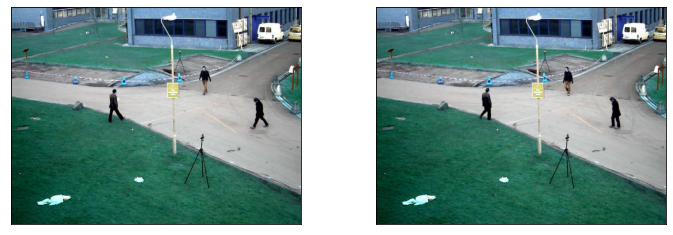

In [7]:
fig = plt.figure(figsize=(12, 4))

fig.add_subplot(121)
plt.imshow(img1)
plt.xticks([])
plt.yticks([])
fig.add_subplot(122)
plt.imshow(img2)
plt.xticks([])
plt.yticks([])

plt.show()

# Lucas Kanade

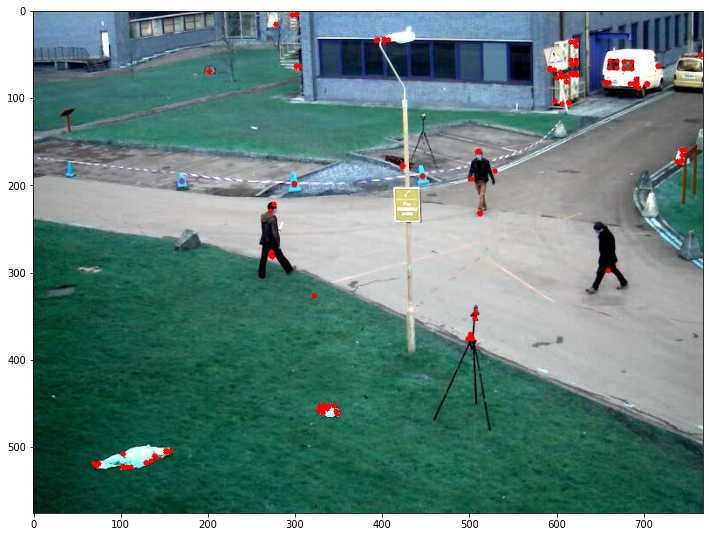

In [19]:
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(img1_gray, mask = None, **feature_params)
corners = np.int0(p0)

for i in corners:
    x,y = i.ravel()
    cv2.circle(img1,(x,y),3,255,-1)

fig = plt.figure(figsize=(12, 10))
plt.imshow(img1)
plt.show()


In [ ]:
p1, st, err = cv2.calcOpticalFlowPyrLK(img1_gray, img2_gray, p0, None, **lk_params)
# Select good points
if p1 is not None:
    good_new = p1[st==1]
    good_old = p0[st==1]

mask = np.zeros_like(img1)
# Create some random colors
color = np.random.randint(0, 255, (100, 3))

# draw the tracks
for i, (new, old) in enumerate(zip(good_new, good_old)):
    a, b = new.ravel()
    c, d = old.ravel()
    mask = cv2.line(mask, (int(a), int(b)), (int(c), int(d)), color[i].tolist(), 2)
    img2 = cv2.circle(img2, (int(a), int(b)), 5, color[i].tolist(), -1)
img = cv2.add(img2, mask)



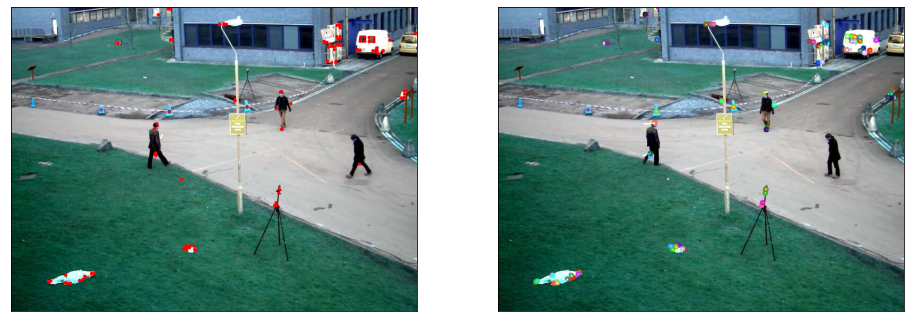

In [24]:
fig = plt.figure(figsize=(16, 16))

fig.add_subplot(121)
plt.imshow(img1)
plt.xticks([])
plt.yticks([])
fig.add_subplot(122)
plt.imshow(img)
plt.xticks([])
plt.yticks([])

plt.show()

In [25]:
import numpy as np
import cv2 as cv
from google.colab.patches import cv2_imshow

pathOut = content_dir + "/output_video.mp4"

cap = cv.VideoCapture(videoPath)
# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )
# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15, 15),
                  maxLevel = 2,
                  criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))
# Create some random colors
color = np.random.randint(0, 255, (100, 3))
# Take first frame and find corners in it
ret, old_frame = cap.read()
img_width = old_frame.shape[1]
img_height = old_frame.shape[0]

output = cv.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), 60, (img_width, img_height))

old_gray = cv.cvtColor(old_frame, cv.COLOR_BGR2GRAY)
p0 = cv.goodFeaturesToTrack(old_gray, mask = None, **feature_params)
# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)
while(1):
    ret, frame = cap.read()
    if not ret:
        print('No frames grabbed!')
        break
    frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    # calculate optical flow
    p1, st, err = cv.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
    # Select good points
    if p1 is not None:
        good_new = p1[st==1]
        good_old = p0[st==1]
    # draw the tracks
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel()
        c, d = old.ravel()
        mask = cv.line(mask, (int(a), int(b)), (int(c), int(d)), color[i].tolist(), 2)
        frame = cv.circle(frame, (int(a), int(b)), 5, color[i].tolist(), -1)
    img = cv.add(frame, mask)
    
    # cv2_imshow(img)
    output.write(img)
    
    k = cv.waitKey(30) & 0xff
    if k == 27:
        break
    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1, 1, 2)
print("Complete")
output.release()
cv.destroyAllWindows()


No frames grabbed!
Complete


# Gunner Farneback

In [27]:
flow = cv2.calcOpticalFlowFarneback(img1_gray, img2_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
mag, ang = cv.cartToPolar(flow[..., 0], flow[..., 1])
hsv = np.zeros_like(img1)
hsv[..., 1] = 255
hsv[..., 0] = ang*180/np.pi/2
hsv[..., 2] = cv.normalize(mag, None, 0, 255, cv.NORM_MINMAX)
bgr = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)


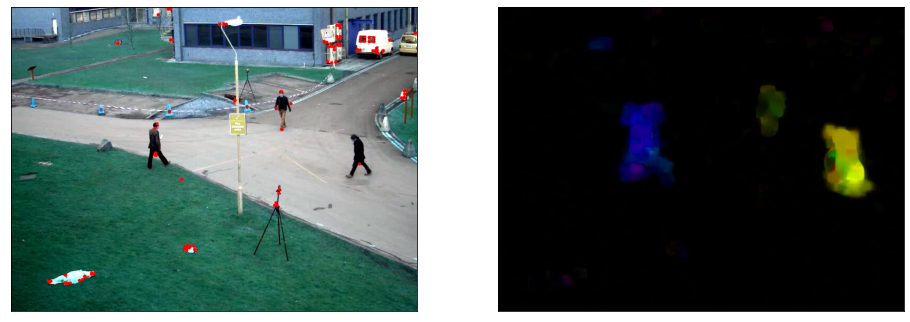

In [28]:
fig = plt.figure(figsize=(16, 16))

fig.add_subplot(121)
plt.imshow(img1)
plt.xticks([])
plt.yticks([])
fig.add_subplot(122)
plt.imshow(bgr)
plt.xticks([])
plt.yticks([])

plt.show()

In [26]:
import numpy as np
import cv2 as cv
cap = cv.VideoCapture(videoPath)
ret, frame1 = cap.read()
prvs = cv.cvtColor(frame1, cv.COLOR_BGR2GRAY)
hsv = np.zeros_like(frame1)
hsv[..., 1] = 255

img_width = frame1.shape[1]
img_height = frame1.shape[0]

output = cv.VideoWriter('GN_output_video_2.mp4',cv.VideoWriter_fourcc(*'DIVX'), 60, (img_width, img_height))


while(1):
    ret, frame2 = cap.read()
    if not ret:
        print('No frames grabbed!')
        break
    next = cv.cvtColor(frame2, cv.COLOR_BGR2GRAY)
    flow = cv.calcOpticalFlowFarneback(prvs, next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    mag, ang = cv.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang*180/np.pi/2
    hsv[..., 2] = cv.normalize(mag, None, 0, 255, cv.NORM_MINMAX)
    bgr = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
    # cv.imshow('frame2', bgr)
    output.write(bgr)
    k = cv.waitKey(30) & 0xff
    if k == 27:
        break
    elif k == ord('s'):
        cv.imwrite('opticalfb.png', frame2)
        cv.imwrite('opticalhsv.png', bgr)
    prvs = next

print("Complete")
output.release()
cv.destroyAllWindows()

No frames grabbed!
Complete
